## Making Flux Ratio maps between H$\alpha$ and CO(2-1) from MUSE and ALMA data

### 1. Data Preparation (WCS Alignment & Registration)

I quickly aligned the ALMA and MUSE WCS by eye (best one can do) using ```pyraf```

```
pyraf --> imdel alma_shift.fits
pyraf --> imshift A2597_mom0.fits alma_shift.fits -4 7
pyraf --> wcscopy alma_shift.fits A2597_mom0.fits
```

Note that I'm using the A2597 ALMA Mom0 map from Tim Davis' code, because the spectral and polarization axes have already been collapsed, and their correspoinding WCS axes have been dropped. Besides, you should use it anyway, as this is the most "believable" flux we can use. 


This provided good alignment between (a) the brightest knot of CO(2-1) and H$\alpha$ emission and (b) that northwestern blob at +400 km/s. Within the physical resolution of our observations, this alignment is good enough.

On to imports: 

In [1]:
import os

from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename

import numpy as np

from reproject import reproject_interp

import matplotlib.pyplot as plt
%matplotlib inline

In [89]:
def styleplots():
    """
    Make plots pretty and labels clear.
    """
    plt.style.use('ggplot')

    labelsizes = 25
    
    plt.rc('font', family='Arial')

    plt.rcParams['font.size'] = labelsizes
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['axes.labelsize'] = labelsizes
    plt.rcParams['xtick.labelsize'] = labelsizes
    plt.rcParams['ytick.labelsize'] = labelsizes
    
    
styleplots()

We need to reproject (resample) one image onto the pixel grid of another, trusting the WCS alignment. This can be done [with the reproject package](https://reproject.readthedocs.io/en/stable/). 

In [3]:
os.listdir('.')

['make_ratio_maps.py',
 'muse_vel.fits',
 'testvelocity.fits',
 'velratio.eps',
 'velratio.fits',
 'Untitled.ipynb',
 'A2597_mom1.fits',
 'Ha_vel_map.fits',
 'ha_to_co_norm (Case Conflict (1)).fits',
 'Ha_flux_map.fits',
 'A2597_mom0.fits',
 'muse_flux.fits',
 'Make_MUSE_ALMA_Ratio_Maps.ipynb',
 'ha_to_CO21_ratio.eps',
 'dispratio.eps',
 'Ha_fwhm_map.fits',
 'ha_to_co_norm (Case Conflict).fits',
 'alma_flux_shift.fits',
 'test_jointplot.pdf',
 'A2597_mom2.fits',
 'alma_vel_shift.fits',
 'fluxpratio.eps',
 'dispratio.fits',
 'alma_shift.fits',
 '.ipynb_checkpoints',
 'ha_to_co_norm.fits',
 'muse_fwhm.fits',
 'ha_to_co_norm (Case Conflict (2)).fits',
 'alma_disp_shift.fits']

In [4]:
museHDU = fits.open(get_pkg_data_filename('Ha_flux_map.fits'))
almaHDU = fits.open(get_pkg_data_filename('alma_shift.fits'))

In [5]:
museHDU.info()

Filename: Ha_flux_map.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      31   (361, 362)   float64   


In [6]:
almaHDU.info()

Filename: alma_shift.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1007   (151, 151)   float64   


Let's look at their WCS structures

In [7]:
w_alma = WCS(almaHDU[0])
w_muse = WCS(museHDU[0])

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [8]:
w_muse

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 351.33208300000001  -12.123889999999999  
CRPIX : 186.99478708022301  177.62417769387  
CD1_1 CD1_2  : -5.5555555555555599e-05  0.0  
CD2_1 CD2_2  : 0.0  5.5555555555555599e-05  
NAXIS : 361  362

In [9]:
w_alma

/Applications/Anaconda/lib/python3.6/site-packages/astropy/wcs/wcs.py:2729: RuntimeWarning: cdelt will be ignored since cd is present
  description.append(s.format(*self.wcs.cdelt))


WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  ''  ''  
CRVAL : 351.33208000000002  -12.124359999999999  0.0  0.0  
CRPIX : 78.000000000000099  72.000000000000099  0.0  0.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -4.1666666666669999e-05  4.1666666666669999e-05  1.0  1.0  
NAXIS : 151  151

There are 4 ALMA WCS axes, including the 2 for frequency and polarization (meaningless in a Mom0 image). We need to collapse along both axes, and drop those WCS axes in order to match the MUSE data. 


In [10]:
alma_3wcs = w_alma.dropaxis(3)
alma_2wcs = alma_3wcs.dropaxis(2)
alma_2wcs

/Applications/Anaconda/lib/python3.6/site-packages/astropy/wcs/wcs.py:2729: RuntimeWarning: cdelt will be ignored since cd is present
  description.append(s.format(*self.wcs.cdelt))


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 351.33208000000002  -12.124359999999999  
CRPIX : 78.000000000000099  72.000000000000099  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -4.1666666666669999e-05  4.1666666666669999e-05  
NAXIS : 151  151

So now we're matching the MUSE data. You need to make a fresh header and HDU out of this. 

In [11]:
newalmaHeader = alma_2wcs.to_header()
newalmaHeader

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                 78.0 / Pixel coordinate of reference point            
CRPIX2  =                 72.0 / Pixel coordinate of reference point            
CDELT1  =  -4.166666666667E-05 / [deg] Coordinate increment at reference point  
CDELT2  =   4.166666666667E-05 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---SIN'           / Right ascension, orthographic/synthesis project
CTYPE2  = 'DEC--SIN'           / Declination, orthographic/synthesis projection 
CRVAL1  =            351.33208 / [deg] Coordinate value at reference point      
CRVAL2  =            -12.12436 / [deg] Coordinate value at reference point      
PV2_1   =                  0.0 / SIN projection parameter                       
PV2_2   =                  0

Now make a "new" ALMA HDU with our old data and new header

In [12]:
newalmaHDU = fits.PrimaryHDU(data=almaHDU[0].data, header=newalmaHeader)

Text(0.5,1,'ALMA Original')

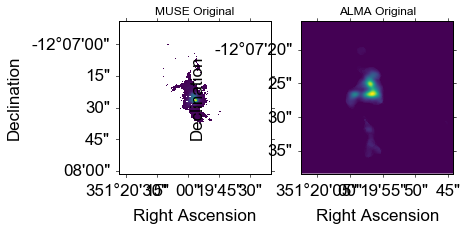

In [13]:
ax1 = plt.subplot(1,2,1, projection=WCS(museHDU[0].header))
ax1.imshow(museHDU[0].data, origin='lower')
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('MUSE Original')

ax2 = plt.subplot(1,2,2, projection=alma_2wcs)
ax2.imshow(newalmaHDU.data, origin='lower')
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel('Declination')
ax2.set_title('ALMA Original')

In [14]:
registered_alma_data, registered_alma_footprint = reproject_interp(newalmaHDU, museHDU[0].header)

Text(0.5,1,'Reprojected ALMA footprint')

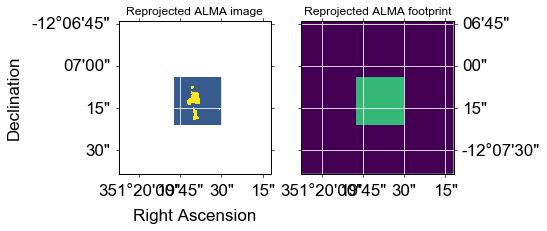

In [15]:
ax1 = plt.subplot(1,2,1, projection=WCS(newalmaHDU.header))
ax1.imshow(registered_alma_data, origin='lower', vmin=-2.e-4, vmax=5.e-4)
ax1.coords.grid(color='white')
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('Reprojected ALMA image')

ax2 = plt.subplot(1,2,2, projection=WCS(newalmaHDU.header))
ax2.imshow(registered_alma_footprint, origin='lower', vmin=0, vmax=1.5)
ax2.coords.grid(color='white')
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax2.coords['dec'].set_axislabel_position('r')
ax2.coords['dec'].set_ticklabel_position('r')
ax2.set_title('Reprojected ALMA footprint')

Text(0.5,1,'Registered ALMA Image')

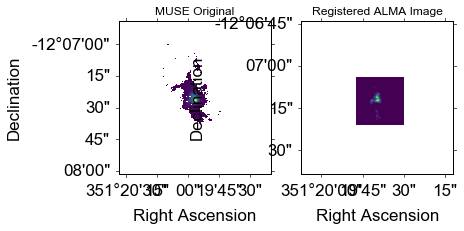

In [16]:
ax1 = plt.subplot(1,2,1, projection=WCS(museHDU[0].header))
ax1.imshow(museHDU[0].data, origin='lower')
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('MUSE Original')

ax2 = plt.subplot(1,2,2, projection=WCS(newalmaHDU.header))
ax2.imshow(registered_alma_data, origin='lower')
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel('Declination')
ax2.set_title('Registered ALMA Image')

Finally, convert the 0s in the reprojected ALMA array to NaNs. 

In [17]:
registered_alma_data[registered_alma_data==0] = np.nan

Text(0.5,1,'Registered ALMA Image')

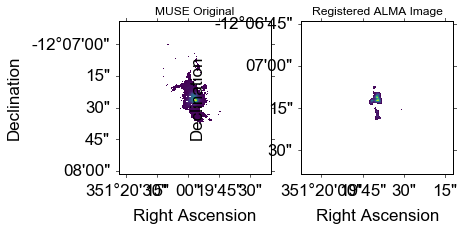

In [18]:
ax1 = plt.subplot(1,2,1, projection=WCS(museHDU[0].header))
ax1.imshow(museHDU[0].data, origin='lower')
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('MUSE Original')

ax2 = plt.subplot(1,2,2, projection=WCS(newalmaHDU.header))
ax2.imshow(registered_alma_data, origin='lower')
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel('Declination')
ax2.set_title('Registered ALMA Image')

## 2. Make functions to do all of this trivially

In [19]:


def fusemusealma(muse_moment_fits, alma_moment_fits):
    '''
    Open MUSE and ALMA HDUs, pick up their WCSs, 
    drop needless ALMA WCS axes, reproject 
    ALMA to MUSE, then output new HDUs.  
    '''
    museHDU = fits.open(get_pkg_data_filename(muse_moment_fits))
    almaHDU = fits.open(get_pkg_data_filename(alma_moment_fits))

    w_alma = WCS(almaHDU[0])
    w_muse = WCS(museHDU[0])

    alma_3wcs = w_alma.dropaxis(3)
    alma_2wcs = alma_3wcs.dropaxis(2)

    newalmaHeader = alma_2wcs.to_header()
    newalmaHDU = fits.PrimaryHDU(data=almaHDU[0].data, header=newalmaHeader)
    
    registered_alma_data, registered_alma_footprint = reproject_interp(newalmaHDU, museHDU[0].header)
    
    # Make the Zeros NaNs
    registered_alma_data[registered_alma_data==0] = np.nan
    
    ax1 = plt.subplot(1,2,1, projection=WCS(museHDU[0].header))
    ax1.imshow(museHDU[0].data, origin='lower')
    ax1.coords['ra'].set_axislabel('Right Ascension')
    ax1.coords['dec'].set_axislabel('Declination')
    ax1.set_title('MUSE Original')

    ax2 = plt.subplot(1,2,2, projection=WCS(newalmaHDU.header))
    ax2.imshow(registered_alma_data, origin='lower')
    ax2.coords['ra'].set_axislabel('Right Ascension')
    ax2.coords['dec'].set_axislabel('Declination')
    ax2.set_title('Registered ALMA Image')
    
    ax1.set_xlim(100, 220)
    ax1.set_ylim(100,300)
    ax2.set_xlim(100, 220)
    ax2.set_ylim(100,300)
    
    plt.show()
    print("Successfully reprojected {} to {}".format(alma_moment_fits, muse_moment_fits))
    
    header = w_muse.to_header()
    
    return museHDU[0].data, registered_alma_data, header

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


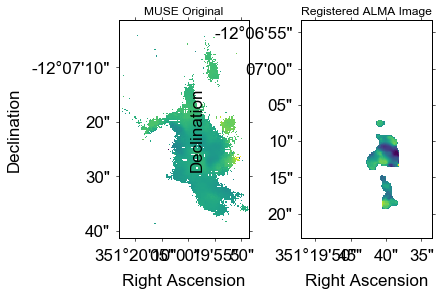

Successfully reprojected alma_vel_shift.fits to Ha_vel_map.fits


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


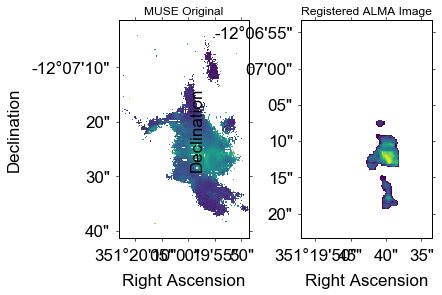

Successfully reprojected alma_disp_shift.fits to Ha_fwhm_map.fits


array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])

In [24]:
#museflux, almaflux, fluxheader = fusemusealma('Ha_flux_map', 'alma_flux_shift.fits')

musevel, almavel, velheader = fusemusealma('Ha_vel_map.fits', 'alma_vel_shift.fits')

velratio = musevel / almavel

velratio_hdu = fits.PrimaryHDU(data=velratio, header=velheader)
velratio_hdu.writeto("velratio.fits", clobber=True)


musedisp, almadisp, dispheader = fusemusealma('Ha_fwhm_map.fits', 'alma_disp_shift.fits')

dispratio = (musedisp/2.35) / almadisp

dispratio_hdu = fits.PrimaryHDU(data=dispratio, header=dispheader)
dispratio_hdu.writeto("dispratio.fits", clobber=True)


musevel


#### Quantify distance from a center point

np.argmax(museflux)

In [63]:
musedisp[musedisp == 0] = np.nan
almadisp[almadisp == 0] = np.nan

In [71]:
np.nanmean(musevel/almavel)

-9089589.4707957562

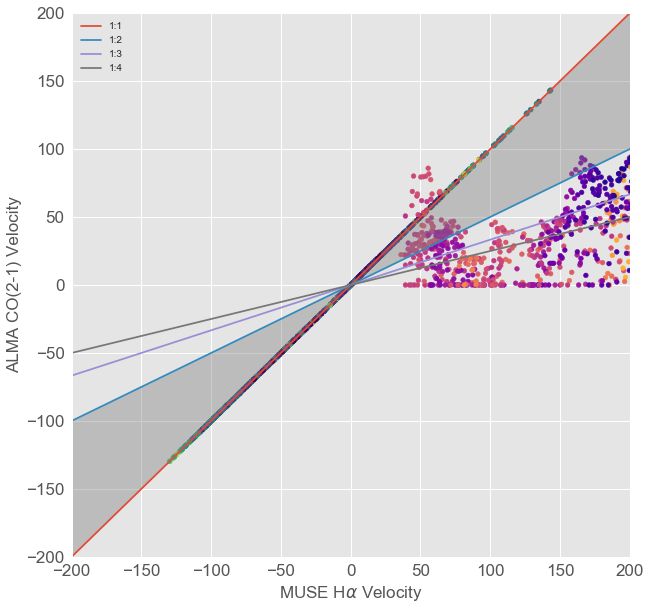

In [75]:
fig, ax = plt.subplots(figsize=(10,10))


styleplots()
#mask = (musevel > 0) & (almavel>0) 

#frame1 = ax.scatter(musevel-np.nanmedian(musevel), almavel, c=almadisp, cmap='viridis', s=25)
frame1 = ax.scatter(musevel-np.nanmedian(musevel), musevel-np.nanmedian(musevel), c=almadisp, cmap='viridis', s=25)

#frame1 = ax.scatter(velratio, dispratio)

#frame2 = ax.scatter(musedisp, almadisp, c=musevel, cmap='plasma', s=22)

frame2 = ax.scatter(musedisp/2.35, almadisp, c=musevel, cmap='plasma', s=22)

ax.set_ylabel("ALMA CO(2-1) Velocity")
ax.set_xlabel(r"MUSE H$\alpha$ Velocity")

x = np.arange(-500,500)
y = np.arange(-500,500)


ax.fill_between(x, y, y/2, facecolor='gray', alpha=0.4)

ax.plot(x,y, label="1:1")
ax.plot(x,y/2, label="1:2")
ax.plot(x,y/3, label="1:3")
ax.plot(x,y/4, label="1:4")


ax.set_ylim(-200,200)
ax.set_xlim(-200,200)

ax.legend()



plt.show()

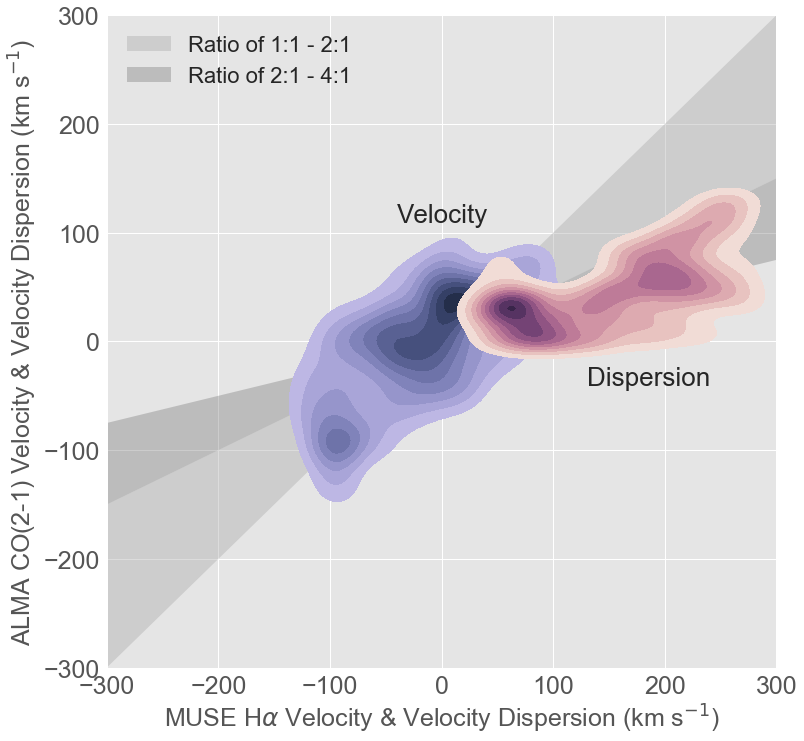

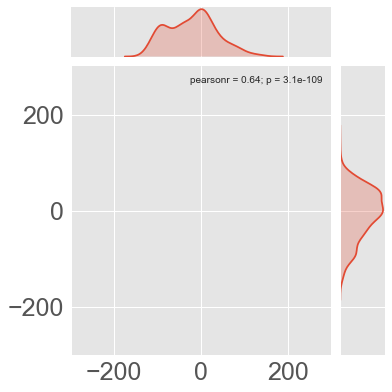

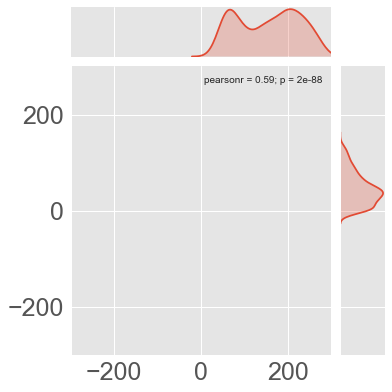

In [90]:

from scipy.stats import kendalltau

import seaborn as sns


fig, ax = plt.subplots(figsize=(12,12))

styleplots()

#sns.set()

#sns.jointplot(musevel, almavel, kind="hex", stat_func=kendalltau, cmap=sns.cubehelix_palette(light=1, as_cmap=True))

lim=300

# sns.jointplot(musevel, almavel, kind="hex", cmap=sns.cubehelix_palette(light=1, as_cmap=True), xlim=(-lim,lim), ylim=(-lim,lim))

cmap1 = sns.cubehelix_palette(light=1, as_cmap=True)
cmap2 = sns.cubehelix_palette(start=2.8, rot=.1, as_cmap=True)



# ax.plot(x,y, label="1:1")
# ax.plot(x,y/2, label="1:2")
# #ax.plot(x,y/3, label="1:3")
# ax.plot(x,y/4, label="1:4")


ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)


ax.fill_between(x, y, y/2, facecolor='darkgray', alpha=0.4, label="Ratio of 1:1 - 2:1")
ax.fill_between(x, y/2, y/4, facecolor='gray', alpha=0.4, label="Ratio of 2:1 - 4:1")

ax.legend(prop={'size': 22}, loc=2)

#sns.jointplot(musevel-np.nanmedian(musevel), almavel-np.nanmedian(almavel), ax=ax, kind="kde", cmap=cmap2,xlim=(-lim,lim), ylim=(-lim,lim),  kernel='gau', shade_lowest=False, dropna=True)

ax.set_xlabel(r"MUSE H$\alpha$ Velocity & Velocity Dispersion (km s$^{-1}$)")
ax.set_ylabel(r"ALMA CO(2-1) Velocity & Velocity Dispersion (km s$^{-1}$)")


sns.jointplot(musevel-np.nanmedian(musevel), almavel-np.nanmedian(almavel), ax=ax, kind="kde", cmap=cmap2,xlim=(-lim,lim), ylim=(-lim,lim),   kernel='gau', shade_lowest=False, dropna=True)
sns.jointplot(musedisp/2.35, almadisp, ax=ax, kind="kde", cmap=cmap1, xlim=(-lim,lim), ylim=(-lim,lim), shade_lowest=False, kernel='gau', shade=True, dropna=True)

ax.text(-40, 110, "Velocity", size=26)
ax.text(130, -40, "Dispersion", size=26)

fig.savefig("muse_alma_kde_plot.pdf", bbox_inches="tight")

#sns.jointplot(musedisp, almadisp, kind="hex", cmap=sns.cubehelix_palette(light=1, as_cmap=True))


In [88]:
import os
os.gcd()

AttributeError: module 'os' has no attribute 'gcd'

/Applications/Anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/bandwidths.py:22: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/Applications/Anaconda/lib/python3.6/site-packages/matplotlib/contour.py:1533: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Applications/Anaconda/lib/python3.6/site-packages/matplotlib/contour.py:1534: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/Applications/Anaconda/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/Applications/Anaconda/lib/python3.6/site-packages/matplotlib/contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
/Applications/Anaconda/lib/python3.6/site-packages/matplotlib/contour.py:1180

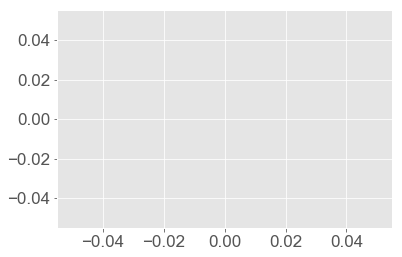

In [67]:
# fig, ax = plt.subplots(figsize=(12,12))


sns.kdeplot(musevel_reshape, almavel_reshape)


ValueError: too many values to unpack (expected 2)

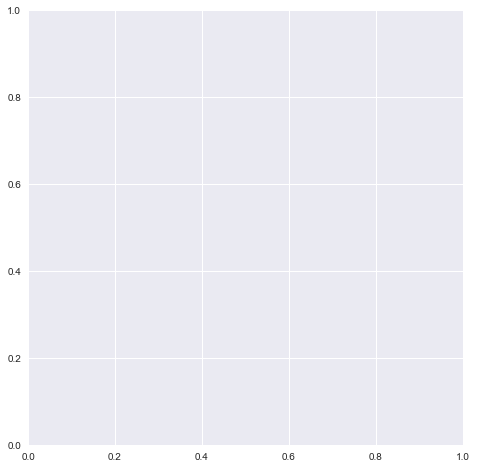

In [68]:
sns.set(style="darkgrid")
iris = sns.load_dataset("iris")

# Subset the iris dataset by species
setosa = iris.query("species == 'setosa'")
virginica = iris.query("species == 'virginica'")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(musedisp, almadisp,
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(virginica.sepal_width, virginica.sepal_length,
                 cmap="Blues", shade=True, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(2.5, 8.2, "virginica", size=16, color=blue)
ax.text(3.8, 4.5, "setosa", size=16, color=red)

In [ ]:
plt.imshow(almavel, origin='lower')
plt.imshow(musevel, origin='lower', cmap='plasma', alpha=0.5)

In [ ]:
plt.imshow(dispratio, origin='lower')

## 2. Map Making

We now have two registered MUSE and ALMA flux density maps for H$\alpha$ and CO(2-1), respectively. 

* The ALMA pixels are in Jy beam$^{-1}$ $\times$ km s$^{-1}$
* The MUSE pixels are in $\times 10^{-20}$ erg s$^{-1}$ cm$^{-2}$ Ang$^{-1}$


In [ ]:
ax1 = plt.subplot(1,2,1)
ax1.imshow(museHDU[0].data, origin='lower')
ax1.set_xlim(100, 220)
ax1.set_ylim(100,300)

ax2 = plt.subplot(1,2,2)
ax2.imshow(registered_alma_data, origin='lower')
ax2.set_xlim(100, 220)
ax2.set_ylim(100,300)


In [ ]:
registered_muse_data = museHDU[0].data

In [ ]:
np.nanmax(registered_muse_data) # We need to use np.nanmax to ignore nans

In [ ]:
np.nanmax(registered_alma_data)

Now you can divide and make the ratio map. This will be especially awesome because of the NaNs - you will automatically crop to the ALMA map, because Number/NaN = NaN. Great!

In [ ]:
peakratio = np.nanmax(registered_muse_data) / np.nanmax(registered_alma_data)
peakratio

In [ ]:
normalized_alma_data = registered_alma_data * peakratio

In [ ]:
Ha_to_CO_norm_data = registered_muse_data / normalized_alma_data

In [ ]:
Ha_to_CO_norm_wcs_header = w_muse.to_header()

In [ ]:
Ha_to_CO_norm_hdu = fits.PrimaryHDU(data=ha_to_co_norm_data, header=ha_to_co_norm_wcs_header)
Ha_to_CO_norm_hdu.writeto("Ha_to_CO_norm.fits", clobber=True)

In [ ]:
ax = plt.subplot()
ax.imshow(Ha_to_CO_norm_data, origin='Lower')
ax.set_xlim = (150, 250)
ax.set_ylim = (150, 250)